In [1]:
import os
data_dir=r'D:\Cdeepmachine\jena_climate'
fname=os.path.join(data_dir,'jena_climate_2009_2016.csv')

In [2]:
f=open(fname)
data=f.read()
f.close()

In [3]:
lines=data.split('\n')
header=lines[0].split(',')
lines=lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [4]:
import numpy as np
float_data=np.zeros((len(lines),len(header)-1))
for i,line in enumerate(lines):
    values=[float(x) for x in line.split(',')[1:]]
    float_data[i,:]=values

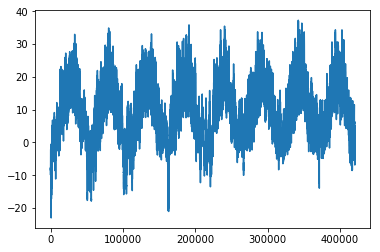

In [5]:
from matplotlib import pyplot as plt
temp=float_data[:,1] 
plt.plot(range(len(temp)),temp)
plt.show()

In [6]:
plt.plot(range(1440),temp[:1440])

In [7]:
mean=float_data[:200000].mean(axis=0)
float_data-=mean
std=float_data[:200000].std(axis=0)
float_data/=std

In [8]:
def generator(data,lookback,delay,min_index,max_index,shuffle=False,batch_size=128,step=6):
    if max_index is None:
        max_index=len(data)-delay-1
    i=min_index+lookback
    while 1:
        if shuffle:
            rows=np.random.randint(min_index+lookback,max_index,size=batch_size)
        else:
            if i+batch_size>=max_index:
                i=min_index+lookback
            rows=np.arange(i,min(i+batch_size,max_index))
            i+=len(rows)
        samples=np.zeros((len(rows),lookback//step,data.shape[-1]))
        targets=np.zeros((len(rows),))
        for j,row in enumerate(rows):
            indices=range(rows[j]-lookback,rows[j],step)
            samples[j]=data[indices]
            targets[j]=data[rows[j]+delay][1]
        yield samples,targets

In [9]:
lookback=1440
step=6
delay=144
batch_size=128
train_gen=generator(float_data,lookback=lookback,delay=delay,min_index=0,max_index=200000,shuffle=True,step=step,batch_size=batch_size)
val_gen=generator(float_data,lookback=lookback,delay=delay,min_index=200001,max_index=300000,step=step,batch_size=batch_size)
test_gen=generator(float_data,lookback=lookback,delay=delay,min_index=300001,max_index=None,step=step,batch_size=batch_size)
val_steps=(300000-200001-lookback)
test_steps=(len(float_data)-300001-lookback)

In [11]:
#baseline
def evaluate_naive_method():
    batch_maes=[]
    for step in range(val_steps):
        samples,targets=next(val_gen)
        preds=samples[:,-1,1]
        mae=np.mean(np.abs(preds-targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.28969941979609765


In [12]:
celsius_mae=0.29*std[1]

In [10]:
# with densely connected model
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model=Sequential()
model.add(layers.Flatten(input_shape=(lookback//step,float_data.shape[-1])))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(1))

Using TensorFlow backend.


In [11]:
model.compile(optimizer=RMSprop(),loss='mae')
history=model.fit_generator(train_gen,steps_per_epoch=500,epochs=20,validation_data=val_gen,validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 653s 1s/step - loss: 1.5082 - val_loss: 0.6560
Epoch 2/20
500/500 [==============================] - 644s 1s/step - loss: 0.5067 - val_loss: 0.4461
Epoch 3/20
500/500 [==============================] - 639s 1s/step - loss: 0.3077 - val_loss: 0.3342
Epoch 4/20
500/500 [==============================] - 643s 1s/step - loss: 0.2710 - val_loss: 0.3017
Epoch 5/20
500/500 [==============================] - 643s 1s/step - loss: 0.2561 - val_loss: 0.3194
Epoch 6/20
500/500 [==============================] - 645s 1s/step - loss: 0.2448 - val_loss: 0.3105
Epoch 7/20
500/500 [==============================] - 644s 1s/step - loss: 0.2391 - val_loss: 0.3339
Epoch 8/20
500/500 [==============================] - 643s 1s/step - loss: 0.2338 - val_loss: 0.3106
Epoch 9/20
500/500 [==============================] - 646s 1s/step - loss: 0.2298 - val_loss: 0.3305
Epoch 10/20
500/500 [==============================] - 645s 1s/step - loss: 0.2244 - val_lo

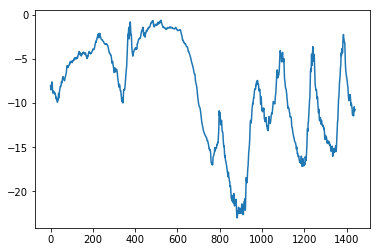

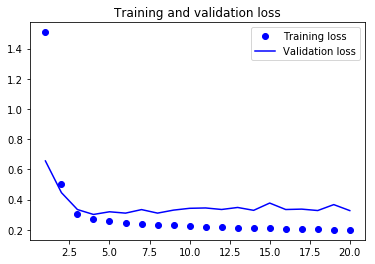

In [12]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [13]:
model=Sequential()
model.add(layers.GRU(32,input_shape=(None,float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(),loss='mae')
history=model.fit_generator(train_gen,steps_per_epoch=500,epochs=20,validation_data=val_gen,validation_steps=val_steps)

Epoch 1/20
499/500 [============================>.] - ETA: 0s - loss: 0.2978

KeyboardInterrupt: 

In [ ]:
#with dropout
model=Sequential()
model.add(layers.GRU(32,dropout=0.2,recurrent_dropout=0.2,input_shape=(None,float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(),loss='mae')
history=model.fit_generator(train_gen,steps_per_epoch=500,epochs=40,validation_data=val_gen,validation_steps=val_steps)

In [ ]:
#stacking
model=Sequential()
model.add(layers.GRU(32,dropout=0.1,recurrent_dropout=0.5,return_sequences=True, input_shape=(None,float_data.shape[-1])))
model.add(layers.GRU(64,activation='relu',dropout=0.1,recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(),loss='mae')
history=model.fit_generator(train_gen,steps_per_epoch=500,epochs=40,validation_data=val_gen,validation_steps=val_steps)

In [2]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features=10000
maxlen=500
(x_train,y_train),(x_test,y_test)=imdb.load_data(num_words=max_features)

x_train=[x[::-1] for x in x_train]
x_test=[x[::-1] for x in x_test]

x_train=sequence.pad_sequences(x_train,maxlen=maxlen)
x_test=sequence.pad_sequences(x_test,maxlen=maxlen)

model=Sequential()
model.add(layers.Embedding(max_features,128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

history=model.fit(x_train,y_train,epochs=10,batch_size=128,validation_split=0.2
                 )

Using TensorFlow backend.


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 86s 4ms/step - loss: 0.4982 - acc: 0.7662 - val_loss: 0.4506 - val_acc: 0.8106
Epoch 2/10
20000/20000 [==============================] - 84s 4ms/step - loss: 0.3178 - acc: 0.8764 - val_loss: 0.3241 - val_acc: 0.8678
Epoch 3/10
20000/20000 [==============================] - 84s 4ms/step - loss: 0.2614 - acc: 0.9028 - val_loss: 0.3358 - val_acc: 0.8602
Epoch 4/10
20000/20000 [==============================] - 85s 4ms/step - loss: 0.2207 - acc: 0.9207 - val_loss: 0.3993 - val_acc: 0.8784
Epoch 5/10
20000/20000 [==============================] - 86s 4ms/step - loss: 0.1927 - acc: 0.9310 - val_loss: 0.3606 - val_acc: 0.8480
Epoch 6/10
20000/20000 [==============================] - 86s 4ms/step - loss: 0.1806 - acc: 0.9363 - val_loss: 0.3517 - val_acc: 0.8780
Epoch 7/10
20000/20000 [==============================] - 86s 4ms/step - loss: 0.1573 - acc: 0.9438 - val_loss: 0.5095 - val_acc:

In [ ]:
model=Sequential()
model.add(layers.Embedding(max_features,32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history=model.fit(x_train,y_train,epochs=10,batch_size=128,validation_split=0.2)

In [ ]:
#bidirectional on temperature
model=Sequential()
model.add(layers.Bidirectional(layers.GRU(32),input_shape=(None,float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(),lose='mae')
history=model.fit_generator(train_gen,steps_per_epoch=500,epochs=40,validation_data=val_gen,validation_steps=val_steps)